/Users/lengjiwei/opt/anaconda3/envs/DS_MiniProject/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Best parameters for IsolationForest: {'contamination': 0.05, 'max_samples': 0.5, 'n_estimators': 300}
Accuracy for IsolationForest: 0.6179202315212322
Classification report for IsolationForest:
              precision    recall  f1-score   support

          -1       0.53      0.07      0.12     88420
           1       0.62      0.96      0.76    141019

    accuracy                           0.62    229439
   macro avg       0.58      0.52      0.44    229439
weighted avg       0.59      0.62      0.51    229439


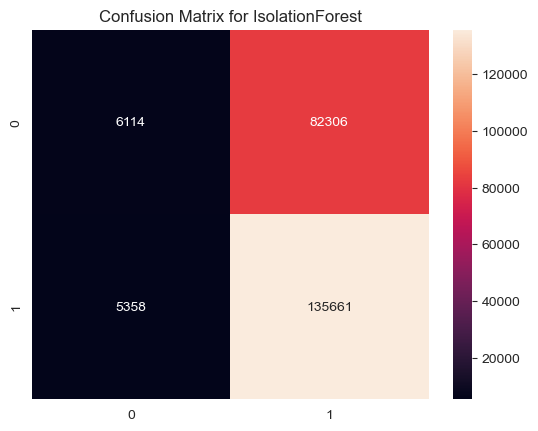

Best parameters for OneClassSVM: {'gamma': 0.05, 'kernel': 'rbf', 'nu': 0.03}
Accuracy for OneClassSVM: 0.6233595857722531
Classification report for OneClassSVM:
              precision    recall  f1-score   support

          -1       0.65      0.05      0.09     88420
           1       0.62      0.98      0.76    141019

    accuracy                           0.62    229439
   macro avg       0.63      0.52      0.43    229439
weighted avg       0.63      0.62      0.50    229439


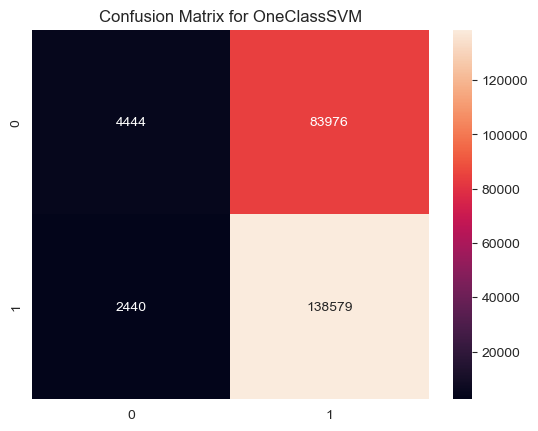

Best parameters for LocalOutlierFactor: {'contamination': 0.05, 'n_neighbors': 50}
Accuracy for LocalOutlierFactor: 0.6104847039953974
Classification report for LocalOutlierFactor:
              precision    recall  f1-score   support

          -1       0.46      0.06      0.11     88420
           1       0.62      0.96      0.75    141019

    accuracy                           0.61    229439
   macro avg       0.54      0.51      0.43    229439
weighted avg       0.56      0.61      0.50    229439


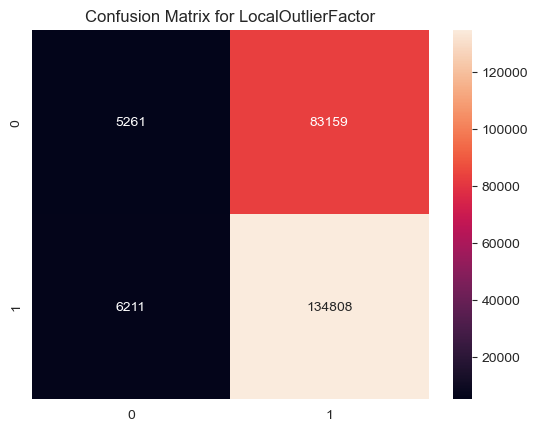

Isolation Forest Feature Importance:
third_party_type: -0.345
is_uk_holiday: 0.345
Balance: 0.300
max_amount: 0.214
min_amount: -0.200
Amount: 0.199
AvgTransactionInterval: 0.191
avg_amount: 0.188
std_amount: 0.187
transaction_count: 0.021
num_third_party: 0.016

One-Class SVM Feature Importance:
Balance: 0.314
num_third_party: -0.243
Amount: 0.231
transaction_count: 0.190
avg_amount: 0.166
third_party_type: -0.140
is_uk_holiday: 0.140
max_amount: 0.118
AvgTransactionInterval: 0.100
min_amount: -0.071
std_amount: -0.018

Local Outlier Factor Feature Importance:
max_amount: 0.088
num_third_party: 0.078
third_party_type: -0.071
is_uk_holiday: 0.071
min_amount: -0.068
std_amount: 0.050
Amount: -0.034
transaction_count: 0.019
Balance: 0.018
avg_amount: 0.017
AvgTransactionInterval: -0.016


In [2]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
file_path = 'simulated_transaction_2024.csv'
data = pd.read_csv(file_path)

# Data preprocessing
data = data.dropna(subset=['Date', 'Timestamp', 'Account No', 'Amount'])
data = data.dropna(subset=['Third Party Account No', 'Third Party Name'], how='all')

data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

data['third_party_type'] = data['Third Party Name'].apply(lambda x: 'Company' if pd.notnull(x) else 'Individual')

transaction_freq = data.groupby('Account No').size().reset_index(name='transaction_count')
data = pd.merge(data, transaction_freq, on='Account No', how='left')

amount_stats = data.groupby('Account No')['Amount'].agg(['mean', 'std', 'max', 'min']).reset_index()
amount_stats.columns = ['Account No', 'avg_amount', 'std_amount', 'max_amount', 'min_amount']
data = pd.merge(data, amount_stats, on='Account No', how='left')

third_party_diversity = data.groupby('Account No')['Third Party Account No'].nunique().reset_index(name='num_third_party')
data = pd.merge(data, third_party_diversity, on='Account No', how='left')

# Define UK holidays for 2023 and 2024
uk_holidays = [
    '2023-01-01',  # New Year's Day
    '2023-01-02',  # New Year's Day (substitute day)
    '2023-04-07',  # Good Friday
    '2023-04-10',  # Easter Monday
    '2023-05-01',  # Early May Bank Holiday
    '2023-05-29',  # Spring Bank Holiday
    '2023-08-28',  # Summer Bank Holiday
    '2023-12-25',  # Christmas Day
    '2023-12-26',  # Boxing Day
    '2024-01-01',  # New Year's Day
    '2024-03-29',  # Good Friday
    '2024-04-01',  # Easter Monday
    '2024-05-06',  # Early May Bank Holiday
    '2024-05-27',  # Spring Bank Holiday
    '2024-08-26',  # Summer Bank Holiday
    '2024-12-25',  # Christmas Day
    '2024-12-26',  # Boxing Day
]

# Optimize time features
data['is_uk_holiday'] = data['Date'].isin(uk_holidays)

# Add balance feature
data['Balance'] = data['Balance'].fillna(0)  # Replace NaN with 0 if needed

# Add average transaction interval feature
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%H:%M')
data['TransactionInterval'] = data.groupby('Account No')['Timestamp'].diff().dt.total_seconds().fillna(0)
data['AvgTransactionInterval'] = data.groupby('Account No')['TransactionInterval'].transform('mean')

# Feature sets
numeric_features = ['Amount', 'transaction_count', 'avg_amount', 'std_amount', 'max_amount', 'min_amount',
                    'num_third_party', 'Balance', 'AvgTransactionInterval']
categorical_features = ['third_party_type', 'is_uk_holiday']

# Preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

data_transformed = preprocessor.fit_transform(data[numeric_features + categorical_features])

# Generate baseline labels using K-Means
kmeans = KMeans(n_clusters=2, random_state=42)
y_kmeans = kmeans.fit_predict(data_transformed)
# Assume the smaller cluster represents fraudulent transactions
if sum(y_kmeans == 0) < sum(y_kmeans == 1):
    y_kmeans = 1 - y_kmeans
y_true = np.where(y_kmeans == 0, 1, -1)

# Hyperparameter tuning and model evaluation
def evaluate_model(model, params, X, y):
    grid_search = GridSearchCV(model, params, cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), scoring='f1', n_jobs=-1)
    grid_search.fit(X, y)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    best_model = model.__class__(**grid_search.best_params_)

    if isinstance(best_model, LocalOutlierFactor):
        y_pred = best_model.fit_predict(X)
    else:
        best_model.fit(X)
        y_pred = best_model.predict(X)

    print(f"Accuracy for {model.__class__.__name__}: {accuracy_score(y, y_pred)}")  # 输出模型准确率

    print(f"Classification report for {model.__class__.__name__}:")
    print(classification_report(y, y_pred))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {model.__class__.__name__}")
    plt.show()
    return best_model, y_pred

# Hyperparameter tuning and evaluation for each model
param_grid_if = {
    'n_estimators': [50, 100, 200, 300],
    'max_samples': [0.5, 'auto', 1.0],
    'contamination': [0.05]
}
clf_if, y_pred_if = evaluate_model(IsolationForest(), param_grid_if, data_transformed, y_true)

param_grid_svm = {
    'nu': [0.005, 0.01, 0.03],
    'kernel': ['rbf'],
    'gamma': [0.01, 0.05, 0.1]
}
clf_svm, y_pred_svm = evaluate_model(OneClassSVM(), param_grid_svm, data_transformed, y_true)

param_grid_lof = {
    'n_neighbors': [10, 20, 30, 50],
    'contamination': [0.05]
}
clf_lof, y_pred_lof = evaluate_model(LocalOutlierFactor(novelty=True), param_grid_lof, data_transformed, y_true)

# Model-based feature evaluation
def get_feature_importance(model, X):
    if isinstance(model, LocalOutlierFactor):
        if model.novelty:
            anomaly_scores = model.score_samples(X) * -1
        else:
            anomaly_scores = model.negative_outlier_factor_ * -1
    elif hasattr(model, 'decision_function'):
        anomaly_scores = model.decision_function(X) * -1
    else:
        anomaly_scores = model.score_samples(X) * -1

    feature_importance = {}
    for i, feature in enumerate(numeric_features + categorical_features):
        feature_importance[feature] = np.corrcoef(X[:, i], anomaly_scores)[0, 1]

    return feature_importance

if_feature_importance = get_feature_importance(clf_if, data_transformed)
svm_feature_importance = get_feature_importance(clf_svm, data_transformed)
lof_feature_importance = get_feature_importance(clf_lof, data_transformed)

print("Isolation Forest Feature Importance:")
for feature, importance in sorted(if_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {importance:.3f}")

print("\nOne-Class SVM Feature Importance:")
for feature, importance in sorted(svm_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {importance:.3f}")

print("\nLocal Outlier Factor Feature Importance:")
for feature, importance in sorted(lof_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {importance:.3f}")

# Weighted voting
weights = {'if': 0.3, 'svm': 0.4, 'lof': 0.3}  # Assign weights to each model

y_pred_weighted = weights['if'] * y_pred_if + weights['svm'] * y_pred_svm + \
                  weights['lof'] * y_pred_lof

y_pred = np.where(y_pred_weighted < 0, -1, 1)

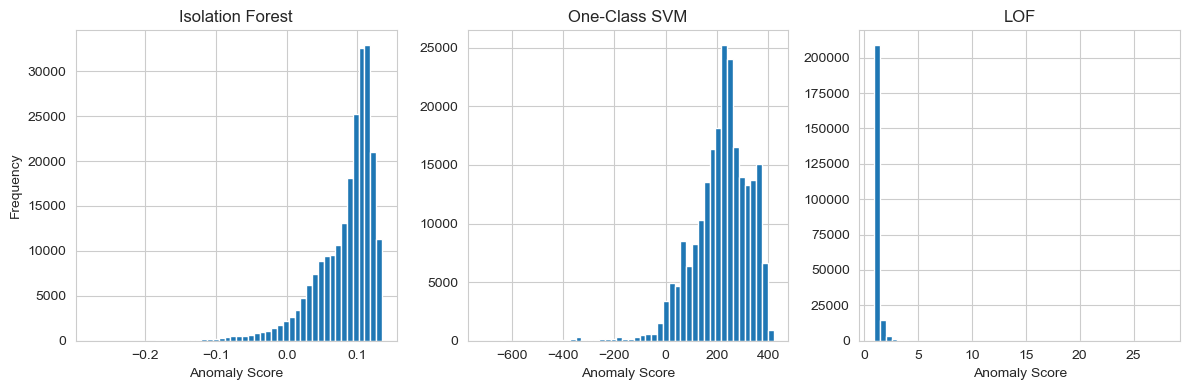

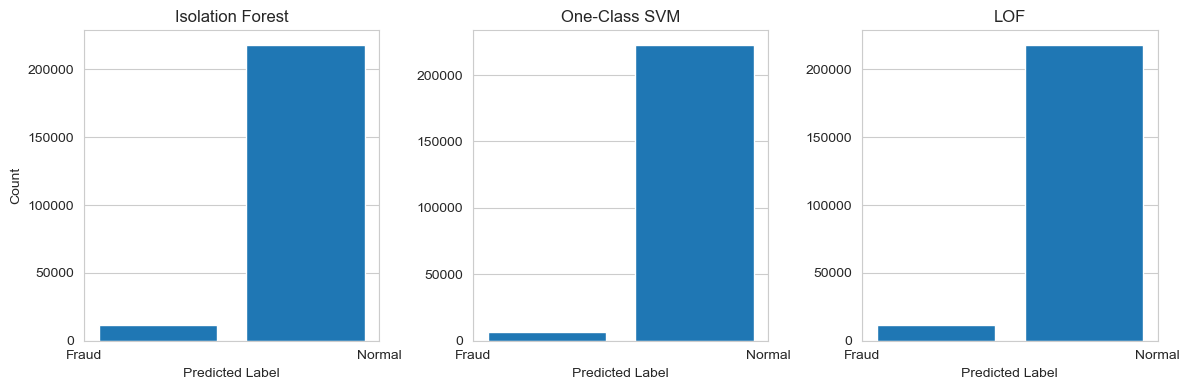

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist(clf_if.decision_function(data_transformed), bins=50)
plt.title('Isolation Forest')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')

plt.subplot(132)
plt.hist(clf_svm.decision_function(data_transformed), bins=50)
plt.title('One-Class SVM')
plt.xlabel('Anomaly Score')

plt.subplot(133)
plt.hist(-clf_lof.negative_outlier_factor_, bins=50)
plt.title('LOF')
plt.xlabel('Anomaly Score')

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.hist(y_pred_if, bins=2, rwidth=0.8)
plt.xticks([1, -1], ['Normal', 'Fraud'])
plt.title('Isolation Forest')
plt.xlabel('Predicted Label')
plt.ylabel('Count')

plt.subplot(132)
plt.hist(y_pred_svm, bins=2, rwidth=0.8)
plt.xticks([1, -1], ['Normal', 'Fraud'])
plt.title('One-Class SVM')
plt.xlabel('Predicted Label')

plt.subplot(133)
plt.hist(y_pred_lof, bins=2, rwidth=0.8)
plt.xticks([1, -1], ['Normal', 'Fraud'])
plt.title('LOF')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

In [4]:
 # Threshold for the risk uses
HIGH_RISK_USER_THRESHOLD = 20
HIGH_RISK_INDIVIDUAL_THIRD_PARTY_THRESHOLD = 10
HIGH_RISK_COMPANY_THIRD_PARTY_THRESHOLD = 10

fraud_transactions = data[y_pred == -1]

user_fraud_count = fraud_transactions.groupby('Account No').size().reset_index(name='fraud_count')
high_risk_users = user_fraud_count[user_fraud_count['fraud_count'] > HIGH_RISK_USER_THRESHOLD]['Account No']

# Identify high-risk individual third-parties
high_risk_transactions = data[(data['Account No'].isin(high_risk_users)) | (data['Third Party Account No'].isin(high_risk_users))]
individual_third_party_risk = high_risk_transactions[high_risk_transactions['third_party_type'] == 'Individual'].groupby('Third Party Account No').size().reset_index(name='risk_count')
high_risk_individual_third_parties = individual_third_party_risk[individual_third_party_risk['risk_count'] > HIGH_RISK_INDIVIDUAL_THIRD_PARTY_THRESHOLD]['Third Party Account No']
high_risk_individual_third_parties = high_risk_individual_third_parties[~high_risk_individual_third_parties.isin(high_risk_users)]

# Identify high-risk company third-parties
company_third_party_risk = high_risk_transactions[high_risk_transactions['third_party_type'] == 'Company'].groupby('Third Party Account No').size().reset_index(name='risk_count')
high_risk_company_third_parties = company_third_party_risk[company_third_party_risk['risk_count'] > HIGH_RISK_COMPANY_THIRD_PARTY_THRESHOLD]['Third Party Account No']
high_risk_company_third_parties = high_risk_company_third_parties[~high_risk_company_third_parties.isin(high_risk_users)]

def generate_report(high_risk_users, high_risk_individual_third_parties, high_risk_company_third_parties):
    report = f"""
Fraud Detection Report
-----------------------
High Risk Users: {len(high_risk_users)}
High Risk Individual Third Parties: {len(high_risk_individual_third_parties)}
High Risk Company Third Parties: {len(high_risk_company_third_parties)}

Details:
High Risk Users: {', '.join(high_risk_users.astype(str))}
High Risk Individual Third Parties: {', '.join(high_risk_individual_third_parties.astype(str))}
High Risk Company Third Parties: {', '.join(high_risk_company_third_parties.astype(str))}
"""
    return report

# Generate report
report = generate_report(high_risk_users, high_risk_individual_third_parties, high_risk_company_third_parties)
print(report)


Fraud Detection Report
-----------------------
High Risk Users: 90
High Risk Individual Third Parties: 30
High Risk Company Third Parties: 0

Details:
High Risk Users: 121858569.0, 133755851.0, 134847904.0, 143003091.0, 146909202.0, 172084472.0, 183888402.0, 199016328.0, 221868392.0, 235881534.0, 252964502.0, 259015404.0, 280200287.0, 285220959.0, 298000165.0, 315078351.0, 315546581.0, 336171116.0, 355940285.0, 370521542.0, 373875019.0, 383833857.0, 386729293.0, 392270893.0, 407323346.0, 450896297.0, 456246119.0, 477216513.0, 478412511.0, 489964679.0, 506618547.0, 518474507.0, 520239952.0, 531186970.0, 532478725.0, 535273662.0, 548638376.0, 549414742.0, 554792076.0, 558119802.0, 559995067.0, 567499591.0, 572384506.0, 576188756.0, 581655972.0, 585625048.0, 592961759.0, 600185455.0, 604870380.0, 607629901.0, 616924659.0, 620227043.0, 639409800.0, 647472692.0, 647936800.0, 651756497.0, 656781737.0, 670427480.0, 679662108.0, 679943657.0, 687135796.0, 691789577.0, 705848712.0, 718058208.0,

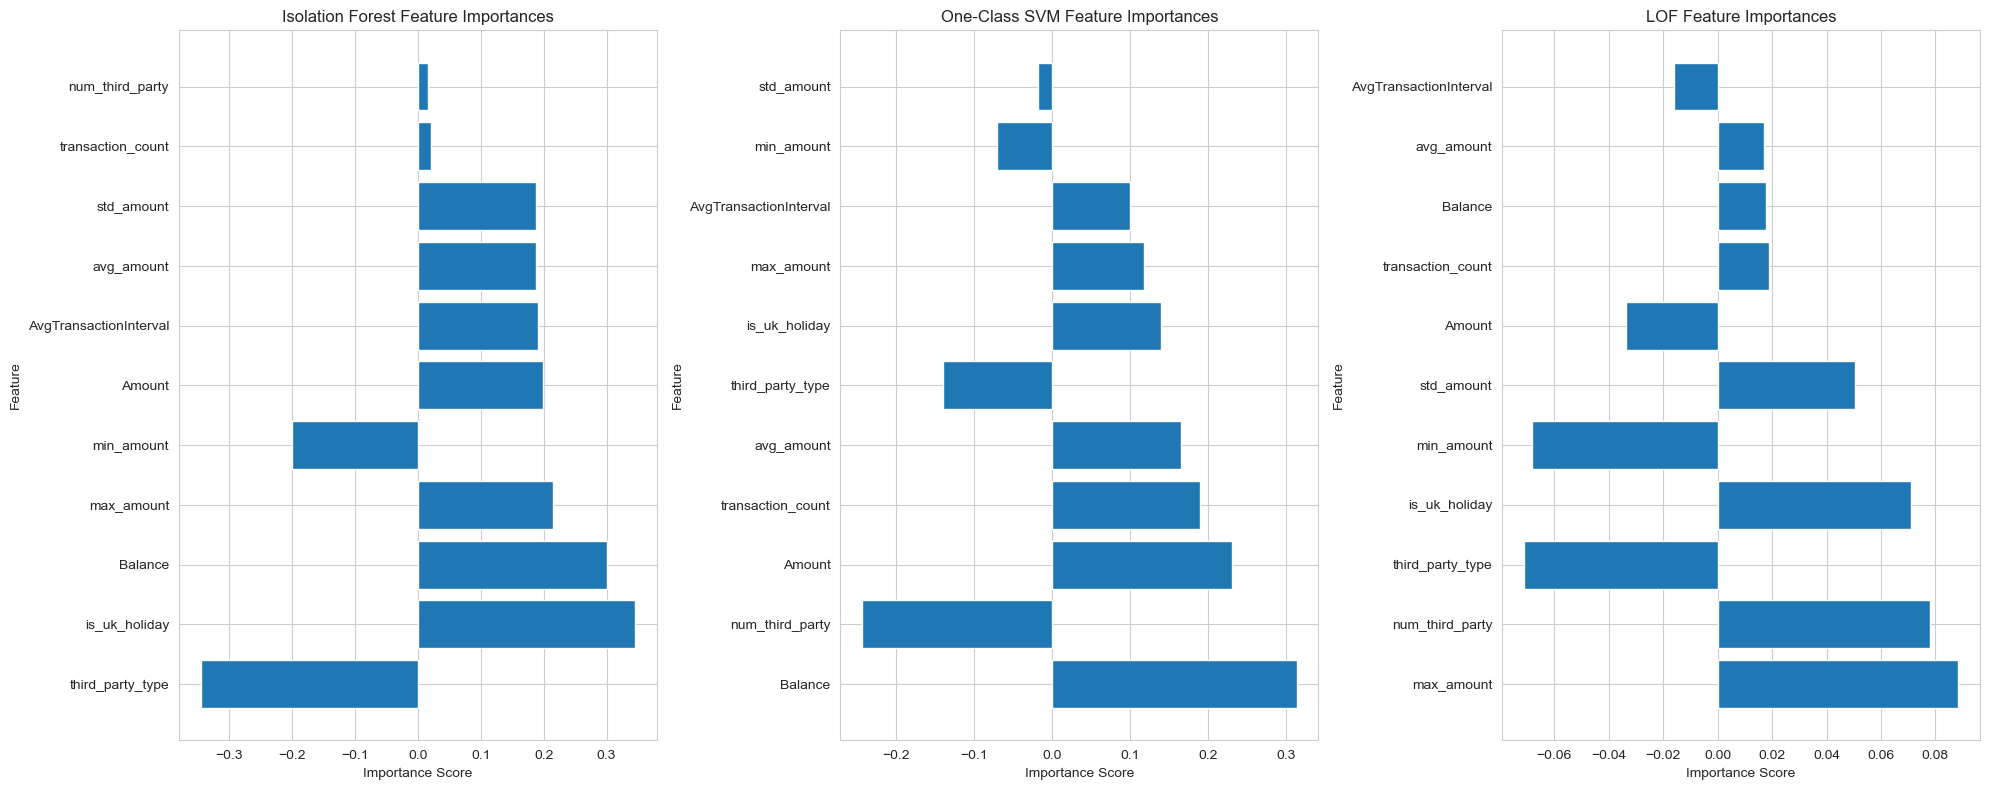

In [5]:
# Feature Importance Visualization
fig, axs = plt.subplots(1, 3, figsize=(20, 8))

# Isolation Forest
importances_if = sorted(if_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)
axs[0].barh([x[0] for x in importances_if], [x[1] for x in importances_if])
axs[0].set_title('Isolation Forest Feature Importances')
axs[0].set_xlabel('Importance Score')
axs[0].set_ylabel('Feature')

# One-Class SVM
importances_svm = sorted(svm_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)
axs[1].barh([x[0] for x in importances_svm], [x[1] for x in importances_svm])
axs[1].set_title('One-Class SVM Feature Importances')
axs[1].set_xlabel('Importance Score')
axs[1].set_ylabel('Feature')

# LOF
importances_lof = sorted(lof_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)
axs[2].barh([x[0] for x in importances_lof], [x[1] for x in importances_lof])
axs[2].set_title('LOF Feature Importances')
axs[2].set_xlabel('Importance Score')
axs[2].set_ylabel('Feature')

plt.tight_layout()
plt.show()

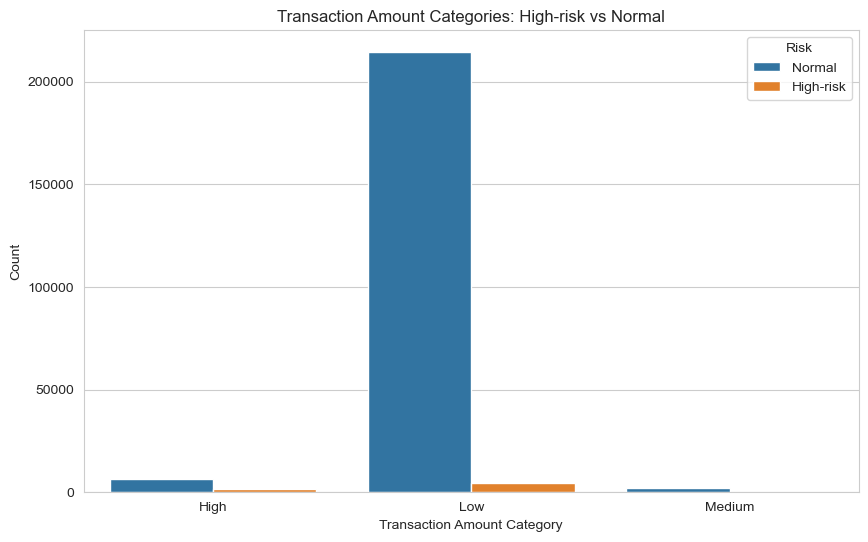

In [6]:

def amount_category(amount):
    if amount < 100:
        return 'Low'
    elif amount < 1000:
        return 'Medium'
    else:
        return 'High'

# 假设 'data' 是原始的数据框架
# 'fraud_transactions' 是被识别为欺诈的交易数据框架
# 'y_pred' 是加权投票的结果

# 将 'y_pred' 转换为一个名为 'Risk' 的类别变量
data['Risk'] = np.where(y_pred == 1, 'Normal', 'High-risk')

# 对金额进行分类
data['Amount_Category'] = data['Amount'].apply(amount_category)

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Amount_Category', hue='Risk', hue_order=['Normal', 'High-risk'])
plt.title('Transaction Amount Categories: High-risk vs Normal')
plt.xlabel('Transaction Amount Category')
plt.ylabel('Count')
plt.show()

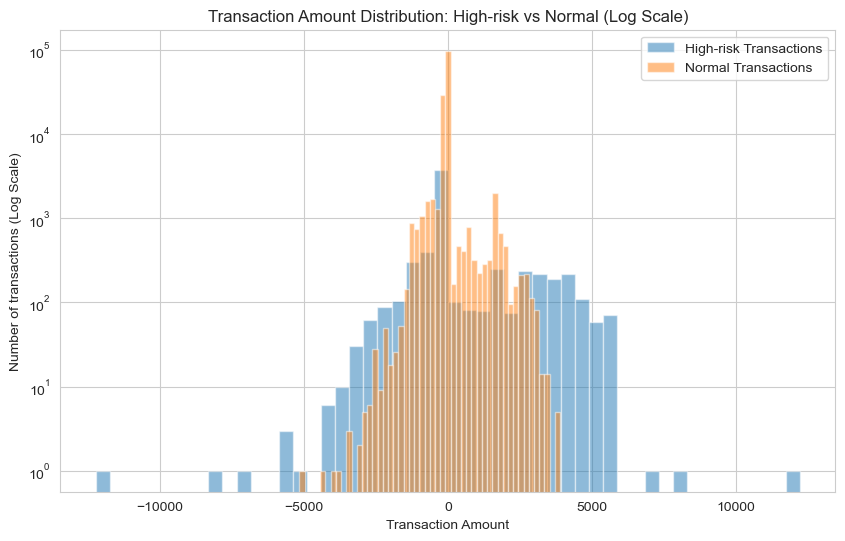

In [7]:
# High-risk vs Normal Transaction Visualization
high_risk_amounts = fraud_transactions['Amount']
normal_amounts = data[y_true == 1]['Amount']

plt.figure(figsize=(10, 6))
plt.hist(high_risk_amounts, bins=50, alpha=0.5, label='High-risk Transactions', log=True)
plt.hist(normal_amounts, bins=50, alpha=0.5, label='Normal Transactions', log=True)
plt.legend()
plt.title('Transaction Amount Distribution: High-risk vs Normal (Log Scale)')
plt.xlabel('Transaction Amount')
plt.ylabel('Number of transactions (Log Scale)')
plt.show()